In [33]:
#Import

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.backends.backend_pdf import PdfPages

## Estimation and analysis of hourly wages across countries over time

In [34]:
# --- 1. LOAD CSV FILES ---
df_emp = pd.read_csv('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/employment_ratio.csv')
df_gdp = pd.read_csv('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/gdp_per_capita_ppp.csv')
df_labsh = pd.read_csv('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/pwt_labor_share_extended.csv')
df_hours = pd.read_csv('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/Hours_extrapolated_1990_2023_selected.csv')


# --- 2. NORMALIZE COLUMN NAMES ---
df_emp.columns = df_emp.columns.str.strip().str.lower()
df_gdp.columns = df_gdp.columns.str.strip().str.lower()
df_labsh.columns = df_labsh.columns.str.strip().str.lower()
df_hours.columns = df_hours.columns.str.strip().str.lower()

print("EMP columns:", df_emp.columns.tolist())
print("GDP columns:", df_gdp.columns.tolist())
print("LABSH columns:", df_labsh.columns.tolist())
print("HOURS columns:", df_hours.columns.tolist())  # Check how the working hours file is structured

# --- 3. MELT (UNPIVOT) THE WIDE DATAFRAMES ---
# For Employment ratio & GDP, we assume: "country code", "country", "series name", plus year columns.
df_emp_melt = df_emp.melt(
    id_vars=["country code", "country", "series name"],
    var_name="year",
    value_name="empratio"
)

df_gdp_melt = df_gdp.melt(
    id_vars=["country code", "country", "series name"],
    var_name="year",
    value_name="gdpcap"
)

# For Labor share (PWT), we assume: "iso code", "country", "variable code", "variable name"
df_labsh_melt = df_labsh.melt(
    id_vars=["iso code", "country", "variable code", "variable name"],
    var_name="year",
    value_name="laborshare"
)

# "Country" in first column, then columns for each year (1990, 1991, ...)
df_hours_melt = df_hours.melt(
    id_vars=["country"],      # keep "country" fixed
    var_name="year",          # melted columns become "year"
    value_name="whours"       # melted values become "whours"
)

# --- 4. RENAME / ALIGN COLUMNS FOR CONSISTENCY ---
df_emp_melt.rename(columns={"country code": "wb_countrycode"}, inplace=True)
df_gdp_melt.rename(columns={"country code": "wb_countrycode"}, inplace=True)
df_labsh_melt.rename(columns={"iso code": "iso_code"}, inplace=True)
# For hours, if you have a separate ISO code or if you rely on "country" only,
# you might later need to do name matching or rename "country" to "iso_code".
# For simplicity, let's assume we match on "country" + "year".

# --- 5. CREATE A COMMON MERGE KEY ---
df_emp_melt["iso_code"] = df_emp_melt["wb_countrycode"]
df_gdp_melt["iso_code"] = df_gdp_melt["wb_countrycode"]

# Convert "year" columns to numeric
for df_ in [df_emp_melt, df_gdp_melt, df_labsh_melt, df_hours_melt]:
    df_["year"] = pd.to_numeric(df_["year"], errors="coerce")

# --- 6. MERGE EMP + GDP + LABOR SHARE ---
df_merged_1 = pd.merge(
    df_emp_melt[["iso_code", "country", "year", "empratio"]],
    df_gdp_melt[["iso_code", "country", "year", "gdpcap"]],
    on=["iso_code", "year"],
    how="outer"
)

df_merged = pd.merge(
    df_merged_1,
    df_labsh_melt[["iso_code", "year", "laborshare"]],
    on=["iso_code", "year"],
    how="outer"
)

# --- 7. CONVERT TO NUMERIC (if not already) ---
df_merged["empratio"]   = pd.to_numeric(df_merged["empratio"], errors="coerce")
df_merged["gdpcap"]     = pd.to_numeric(df_merged["gdpcap"], errors="coerce")
df_merged["laborshare"] = pd.to_numeric(df_merged["laborshare"], errors="coerce")

# >>>>> INSERTED CODE: Unify country columns <<<<<
# Rename one of the duplicate country columns to "country" and drop the other
df_merged.rename(columns={"country_x": "country"}, inplace=True)
if "country_y" in df_merged.columns:
    df_merged.drop(columns=["country_y"], inplace=True)
# -----------------------------------------------------

# --- 8. MERGE WORKING HOURS ---
# Merge on "country" + "year"
df_final = pd.merge(
    df_merged,
    df_hours_melt[["country", "year", "whours"]],
    on=["country", "year"],
    how="inner"  # or "outer" if you want to keep all rows and then filter missing
)

# --- 9. FILTER OUT ROWS THAT LACK ANY COMPONENT (we only want complete data) ---
df_final = df_final.dropna(subset=["empratio", "gdpcap", "laborshare", "whours"])

# --- 10. COMPUTE ESTIMATED HOURLY WAGE ---
df_final["empratio_fraction"] = df_final["empratio"] / 100.0

def compute_est_hourly_wage(row):
    print(
        f"{row['country']}, {row['year']}, "
        f"empratio={row['empratio']}, gdpcap={row['gdpcap']}, "
        f"laborshare={row['laborshare']}, whours={row['whours']}"
    )
    annual_wage = (row["gdpcap"] * row["laborshare"]) / (row["empratio"] / 100.0)
    hourly_wage = annual_wage / row["whours"]
    print("Hourly wage =>", hourly_wage)
    return hourly_wage

df_final["estimated_hourly_wage"] = df_final.apply(compute_est_hourly_wage, axis=1)

# --- 10a. APPLY LOGARITHMIC TRANSFORMATION ---
# Using a log transformation for robustness
df_final["log_estimated_hourly_wage"] = np.log(df_final["estimated_hourly_wage"])

# --- 11. EXPORT RESULTS ---
output_file = "./Countries_Wages_Estimates_GOOD.csv" # Changed to current directory
df_final.to_csv(output_file, index=False)
print(f"Done! '{output_file}' created with 'estimated_hourly_wage' and its log-transformation.")

# 12. LOAD OECD BENCHMARK

df_oecd = pd.read_csv('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/OECD_wages_merged.csv')
df_oecd.rename(columns={'Country':'country','Wages':'oecd_annual_wage','Year':'year'}, inplace=True)
df_oecd['year'] = pd.to_numeric(df_oecd['year'], errors='coerce')

# 13. MERGE INTO df_compare
df_compare = pd.merge(
    df_final,
    df_oecd[['country','year','oecd_annual_wage']],
    on=['country','year'],
    how='inner'
)

# 14. COMPUTE OECD HOURLY WAGE
df_compare['oecd_hourly_wage'] = df_compare['oecd_annual_wage'] / df_compare['whours']

# Now df_compare is available for groupbys and plotting
print("df_compare created with", len(df_compare), "rows")

Streaming output truncated to the last 5000 lines.
Croatia, 1992, empratio=50.599, gdpcap=17004.81607, laborshare=0.642977237701416, whours=1800.0
Hourly wage => 12.004749395913898
Croatia, 1993, empratio=50.151, gdpcap=15556.2956, laborshare=0.642977237701416, whours=1750.0
Hourly wage => 11.396831823612338
Croatia, 1994, empratio=49.823, gdpcap=16286.983, laborshare=0.642977237701416, whours=1700.0
Hourly wage => 12.36395586237625
Croatia, 1995, empratio=49.479, gdpcap=17508.14618, laborshare=0.642977237701416, whours=1924.0
Hourly wage => 11.825235028087262
Croatia, 1996, empratio=49.207, gdpcap=18834.27166, laborshare=0.654904842376709, whours=1924.0
Hourly wage => 13.028519758687139
Croatia, 1997, empratio=48.717, gdpcap=20093.75356, laborshare=0.660953342914581, whours=1924.0
Hourly wage => 14.169230678742268
Croatia, 1998, empratio=47.371, gdpcap=20558.82581, laborshare=0.686233162879944, whours=1924.0
Hourly wage => 15.479338175810216
Croatia, 1999, empratio=45.834, gdpcap=2047

In [35]:
# 1. Extract the list of unique countries
countries_list = df_final["country"].dropna().unique().tolist()

# 2. Get the count
num_countries = len(countries_list)

print(f"Number of countries with estimated wages: {num_countries}")
print("List of countries:", countries_list)


Number of countries with estimated wages: 124
List of countries: ['Angola', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Burkina Faso', 'Bulgaria', 'Bahrain', 'Bahamas, The', 'Bosnia and Herzegovina', 'Belarus', 'Bolivia', 'Brazil', 'Barbados', 'Botswana', 'Central African Republic', 'Canada', 'Switzerland', 'Chile', 'China', 'Cameroon', 'Colombia', 'Cabo Verde', 'Costa Rica', 'Cyprus', 'Czechia', 'Germany', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'Spain', 'Estonia', 'Finland', 'Fiji', 'France', 'Gabon', 'United Kingdom', 'Georgia', 'Guinea', 'Greece', 'Guatemala', 'Hong Kong SAR, China', 'Honduras', 'Croatia', 'Hungary', 'Indonesia', 'India', 'Ireland', 'Iran, Islamic Rep.', 'Iraq', 'Iceland', 'Italy', 'Jamaica', 'Jordan', 'Japan', 'Kazakhstan', 'Kenya', 'Kyrgyz Republic', 'Korea, Rep.', 'Kuwait', 'Lao PDR', 'Lebanon', 'Sri Lanka', 'Lesotho', 'Luxembourg', 'Latvia', 'Macao SAR, China', 'Morocco', 'Moldova', 'Mexi

In [36]:
df_final.head()

,iso_code,country,year,empratio,gdpcap,laborshare,whours,empratio_fraction,estimated_hourly_wage,log_estimated_hourly_wage
0,AGO,Angola,1991,64.287,7218.441432,0.284385,2100.0,0.64287,1.520573,0.419087
1,AGO,Angola,1992,64.229,6578.068575,0.284385,2100.0,0.64229,1.386929,0.327092
2,AGO,Angola,1993,63.937,4843.155884,0.284385,2100.0,0.63937,1.025801,0.025474
3,AGO,Angola,1994,63.965,4751.471649,0.284385,2100.0,0.63965,1.005941,0.005924
4,AGO,Angola,1995,64.298,5284.703133,0.284385,2100.0,0.64298,1.113038,0.107093


In [37]:
df_compare.head()

,iso_code,country,year,empratio,gdpcap,laborshare,whours,empratio_fraction,estimated_hourly_wage,log_estimated_hourly_wage,oecd_annual_wage,oecd_hourly_wage
0,AUS,Australia,1991,57.218,35587.56324,0.617311,1850.0,0.57218,20.753815,3.032730,48312.881,26.115071
1,AUS,Australia,1992,56.240,35342.06871,0.607276,1847.0,0.56240,20.661684,3.028281,49299.641,26.691738
2,AUS,Australia,1993,55.787,36446.61276,0.601340,1864.0,0.55787,21.076480,3.048158,49760.776,26.695695
3,AUS,Australia,1994,56.943,37534.09511,0.604075,1870.0,0.56943,21.292915,3.058374,50097.396,26.790051
4,AUS,Australia,1995,58.283,38560.77734,0.607524,1870.0,0.58283,21.494402,3.067793,49917.855,26.694040


## Costa Rica

In [38]:
# Initial slope and intercept for Costa Rica

# Filter the merged dataframe for Costa Rica and drop any missing values
df_cr = df_compare[df_compare["country"] == "Costa Rica"].dropna(subset=["estimated_hourly_wage", "oecd_hourly_wage"]).sort_values("year")

if len(df_cr) < 2:
    print("Not enough data for Luxembourg to run a regression.")
else:
    # Prepare the predictor and response variables
    X = df_cr[["estimated_hourly_wage"]].values  # Estimated wage as predictor
    y = df_cr["oecd_hourly_wage"].values           # True OECD hourly wage as response

    # Fit the linear regression model: true wage = intercept + slope * estimated wage
    model = LinearRegression().fit(X, y)
    intercept = round(model.intercept_, 3)
    slope = round(model.coef_[0], 3)

    print("Regression results for Costa Rica:")
    print("Intercept:", intercept)
    print("Slope:", slope)


Regression results for Costa Rica:
Intercept: 1.033
Slope: 1.397


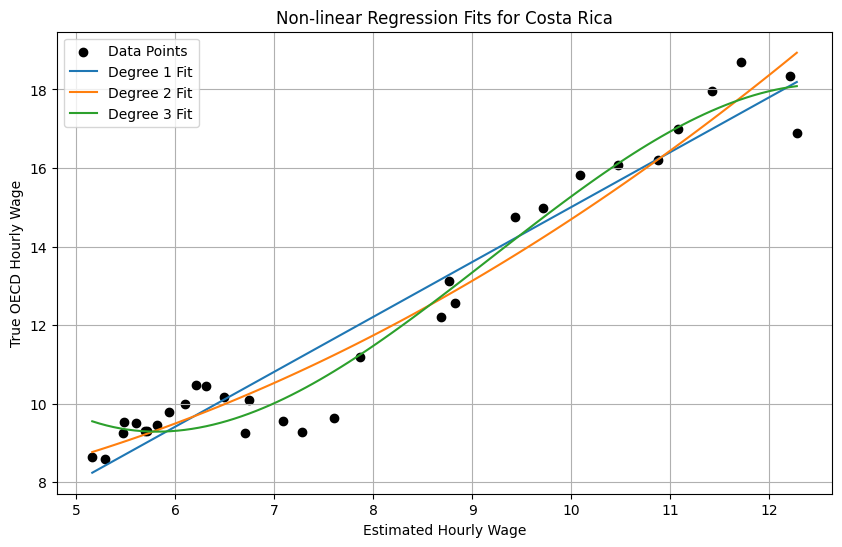

Regression parameters for Costa Rica (rounded to 3 decimals):
degree_1: Intercept = 1.033, Slope (local derivative at mean) = 1.397
degree_2: Intercept = 7.058, Slope (local derivative at mean) = 1.289
degree_3: Intercept = 40.265, Slope (local derivative at mean) = 1.697


In [39]:
# Can be ignored # First code to try to see Costa Rica estimate with non linear regressions, doesn't improve, so need to check with adding a variable

# ---- Configuration ----
# Set a manual adjustment factor (e.g., to adjust for oil revenue anomaly)
adjustment_factor = 0.0  # change this value as needed; set to 0 for no adjustment

# Select the degrees of polynomial to test: 1 = linear, 2 = quadratic, 3 = cubic
degrees = [1, 2, 3]

# ---- Data Preparation ----
# Filter the merged dataframe for Costa Rica, drop missing values, and sort by year
df_cr = df_compare[df_compare["country"] == "Costa Rica"].dropna(subset=["estimated_hourly_wage", "oecd_hourly_wage"]).sort_values("year")

if len(df_cr) < 2:
    print("Not enough data for Costa Rica to run a regression.")
else:
    # Prepare predictor and response variables.
    # Apply a manual adjustment (if any) to estimated wage:
    X = (df_cr[["estimated_hourly_wage"]].values - adjustment_factor)
    y = df_cr["oecd_hourly_wage"].values

    # Create a range for plotting predictions. We'll use a fine grid between min and max estimated wage.
    X_plot = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

    # We'll store results for printing later.
    results = {}

    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color="black", label="Data Points")

    # We'll compute the mean estimated wage (after adjustment) to use for derivative calculation.
    X_mean = np.mean(X)

    for deg in degrees:
        # Create a pipeline with PolynomialFeatures and LinearRegression
        model = Pipeline([
            ('poly', PolynomialFeatures(degree=deg, include_bias=False)),
            ('lin_reg', LinearRegression())
        ])
        model.fit(X, y)
        y_pred = model.predict(X_plot)

        # For degree=1, we can easily get intercept and slope.
        if deg == 1:
            intercept = model.named_steps["lin_reg"].intercept_
            slope = model.named_steps["lin_reg"].coef_[0]
        else:
            # For non-linear models, we compute the derivative at the mean of X.
            # The polynomial model is: f(x) = c0*x + c1*x^2 + ... + c_{deg-1} * x^deg + intercept.
            # Its derivative is: f'(x) = c0 + 2*c1*x + ... + deg*c_{deg-1} * x^(deg-1)
            lin_coefs = model.named_steps["lin_reg"].coef_
            intercept = model.named_steps["lin_reg"].intercept_
            derivative = lin_coefs[0]
            for d in range(2, deg+1):
                derivative += d * lin_coefs[d-1] * (X_mean ** (d-1))
            slope = derivative

        # Store rounded results (3 decimals)
        results[f"degree_{deg}"] = {"intercept": round(intercept, 3),
                                    "slope (deriv at mean)": round(slope, 3)}

        # Plot the fitted curve
        plt.plot(X_plot + adjustment_factor, y_pred, label=f"Degree {deg} Fit")

    plt.xlabel("Estimated Hourly Wage" + (" (adjusted)" if adjustment_factor else ""))
    plt.ylabel("True OECD Hourly Wage")
    plt.title("Non-linear Regression Fits for Costa Rica")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the regression parameters for each model
    print("Regression parameters for Costa Rica (rounded to 3 decimals):")
    for key, params in results.items():
        print(f"{key}: Intercept = {params['intercept']}, Slope (local derivative at mean) = {params['slope (deriv at mean)']}")


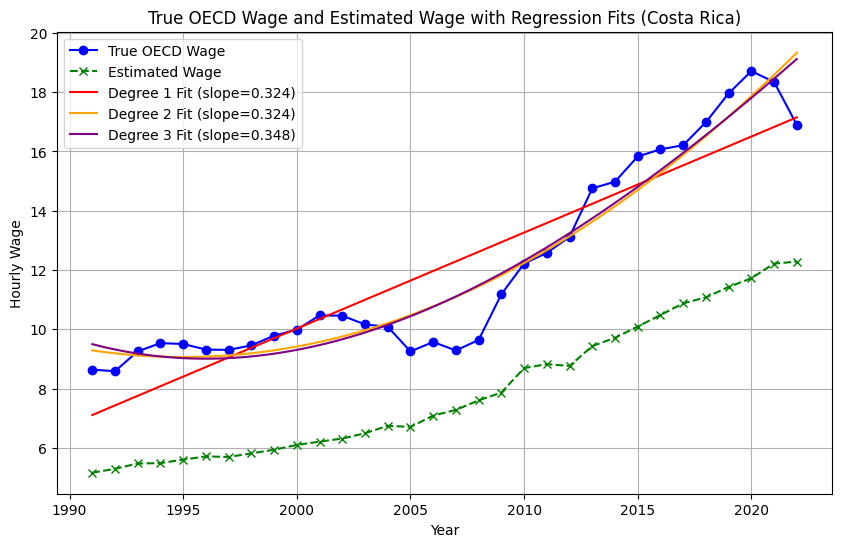

Regression parameters for Costa Rica (using year as predictor):
degree_1: Intercept = -637.754, Slope (local derivative at mean) = 0.324
degree_2: Intercept = 55982.515, Slope (local derivative at mean) = 0.324
degree_3: Intercept = 1321639.216, Slope (local derivative at mean) = 0.348


In [40]:
# IGNORE AS WELL # Second code with the plots

# Filter the merged dataframe for Costa Rica, drop missing values, and sort by year
ddf_cr = df_compare[df_compare["country"] == "Costa Rica"].dropna(
    subset=["estimated_hourly_wage", "oecd_hourly_wage"]
).sort_values("year")

if len(df_cr) < 2:
    print("Not enough data for Costa Rica to run a regression.")
else:
    # Use "year" as the predictor
    X_year = df_cr[["year"]].values
    # True OECD hourly wage (as reported) and our estimated wage
    y_true = df_cr["oecd_hourly_wage"].values
    y_est = df_cr["estimated_hourly_wage"].values

    # Create a grid for plotting regression predictions
    X_plot = np.linspace(df_cr["year"].min(), df_cr["year"].max(), 100).reshape(-1,1)

    # Start plotting: plot both the true OECD wage and the estimated wage over time
    plt.figure(figsize=(10,6))
    plt.plot(df_cr["year"], y_true, color="blue", marker="o", linestyle="-", label="True OECD Wage")
    plt.plot(df_cr["year"], y_est, color="green", marker="x", linestyle="--", label="Estimated Wage")

    # Dictionary to store regression parameters for each model
    results = {}
    degrees = [1, 2, 3]
    colors = ["red", "orange", "purple"]

    for i, deg in enumerate(degrees):
        # Create a pipeline to fit a polynomial regression model of specified degree
        model = Pipeline([
            ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
            ("lin_reg", LinearRegression())
        ])
        model.fit(X_year, y_true)
        y_pred = model.predict(X_plot)

        # For linear (degree 1), we can directly obtain slope and intercept
        if deg == 1:
            intercept = model.named_steps["lin_reg"].intercept_
            slope = model.named_steps["lin_reg"].coef_[0]
        else:
            # For polynomial regression, approximate the local slope by computing the derivative at the mean year.
            coefs = model.named_steps["lin_reg"].coef_
            intercept = model.named_steps["lin_reg"].intercept_
            X_mean = np.mean(X_year)
            # The polynomial model: y = c0*x + c1*x^2 + ... + c_{deg-1}*x^deg + intercept
            # Its derivative is: f'(x) = c0 + 2*c1*x + ... + deg*c_{deg-1}*x^(deg-1)
            slope = sum((d+1) * coefs[d] * (X_mean ** d) for d in range(len(coefs)))

        # Round the regression parameters to 3 decimals
        intercept = round(intercept, 3)
        slope = round(slope, 3)
        results[f"degree_{deg}"] = {"intercept": intercept, "slope (local derivative at mean)": slope}

        # Plot the fitted regression curve
        plt.plot(X_plot, y_pred, color=colors[i], linestyle="-", label=f"Degree {deg} Fit (slope={slope})")

    plt.xlabel("Year")
    plt.ylabel("Hourly Wage")
    plt.title("True OECD Wage and Estimated Wage with Regression Fits (Costa Rica)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the regression parameters for each model
    print("Regression parameters for Costa Rica (using year as predictor):")
    for key, params in results.items():
        print(f"{key}: Intercept = {params['intercept']}, Slope (local derivative at mean) = {params['slope (local derivative at mean)']}")


Index(['Year', 'Total employment in tourism industries per 1,000 people',
       'Air transport, passengers carried (person)',
       'Ratio of inbound to outbound tourist trips',
       'Total number of international immigrants',
       'Agriculture, forestry, and fishing, value added per worker (constant 2015 US$)',
       'Share of workers informally employed in non-agricultural workplaces',
       'National Minimum Wage (in US dollars)',
       'School enrollment, secondary (% gross)'],
      dtype='object')
Plot saved to Project_Wage_Convergence/Costa Rica_Wage_vs_air_passengers_carried.pdf


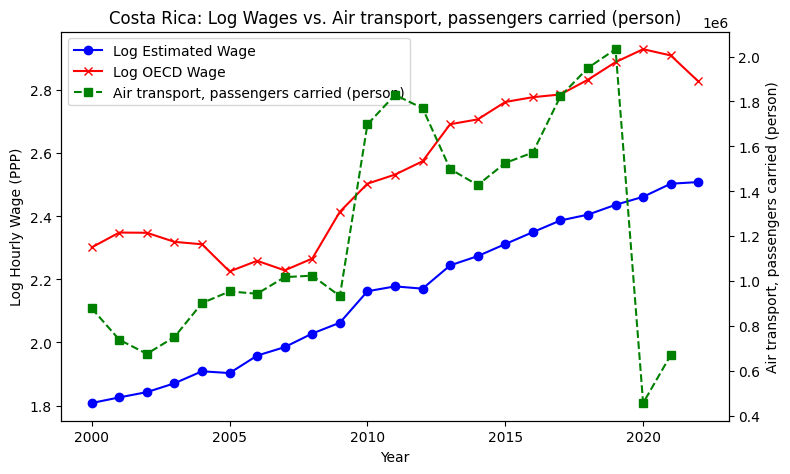

Plot saved to Project_Wage_Convergence/Costa Rica_Wage_vs_inbound_outbound_tourism_ratio.pdf


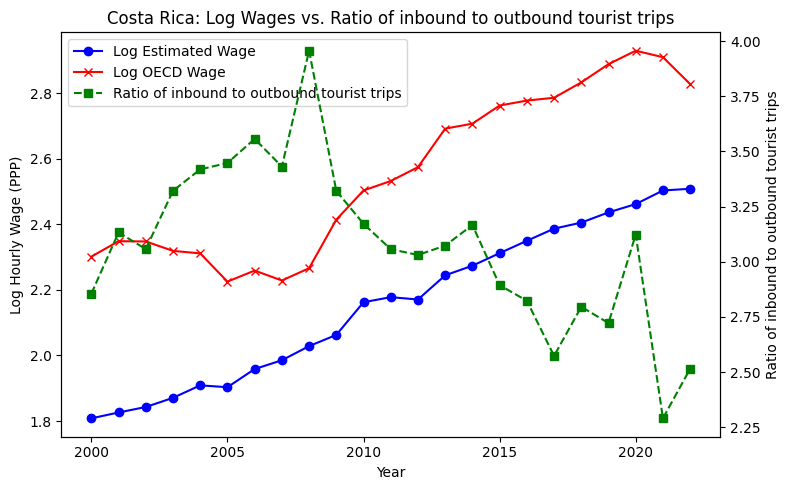

Plot saved to Project_Wage_Convergence/Costa Rica_Wage_vs_agriculture_value_added_per_worker.pdf


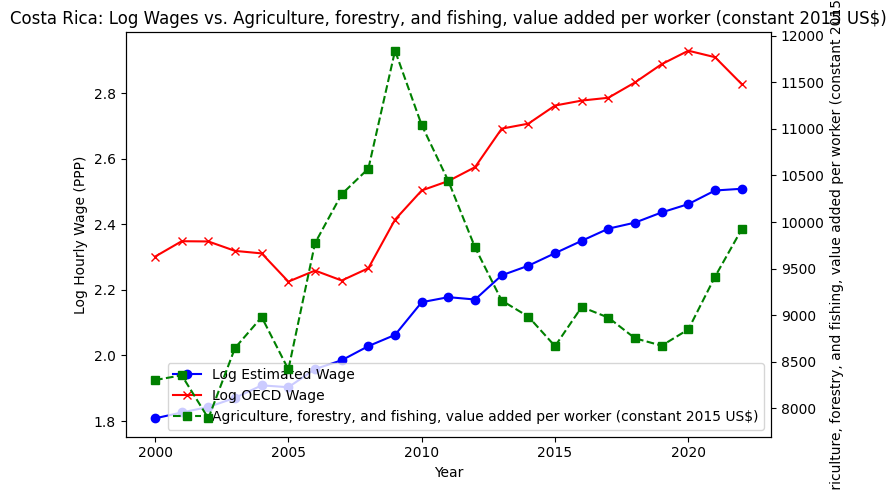

Plot saved to Project_Wage_Convergence/Costa Rica_Wage_vs_national_minimum_wage_usd.pdf


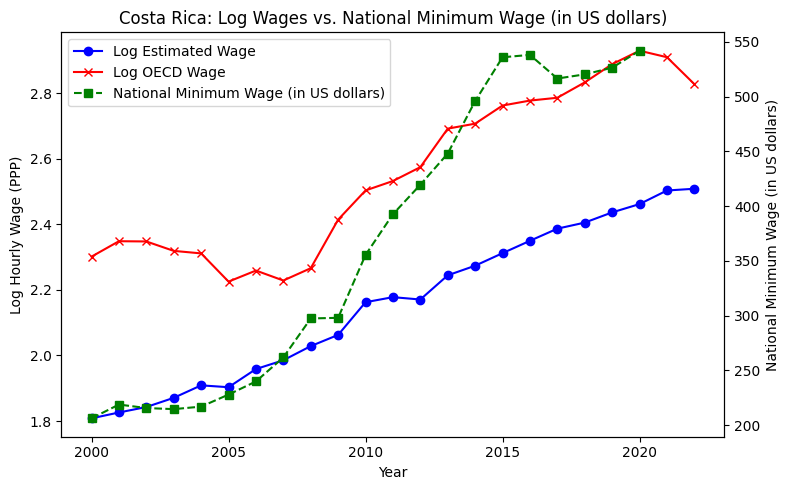

Plot saved to Project_Wage_Convergence/Costa Rica_Wage_vs_secondary_school_enrollment_pct.pdf


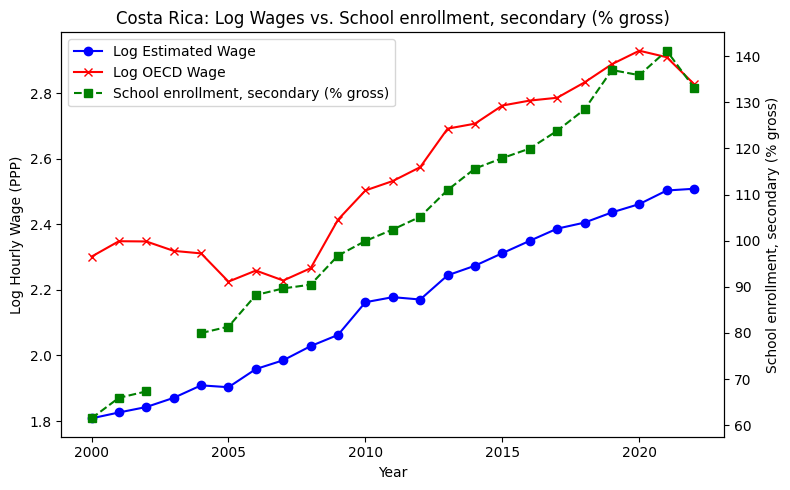

In [41]:
# Comparing Costa Rica added variables, estimate wages and true wages

# 1. Load your existing wage data
df_est = pd.read_csv(os.path.expanduser('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/Countries_Wages_Estimates_Finals_GOOD.csv'))
df_oecd = pd.read_csv(os.path.expanduser('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/OECD_wages_merged.csv'))
df_oecd.rename(columns={"Country": "country", "Wages": "oecd_annual_wage", "Year": "year"}, inplace=True)
df_oecd["year"] = pd.to_numeric(df_oecd["year"], errors="coerce")

df_compare = pd.merge(
    df_est,
    df_oecd[["country", "year", "oecd_annual_wage"]],
    on=["country", "year"],
    how="inner"
)

df_compare["oecd_hourly_wage"] = df_compare["oecd_annual_wage"] / df_compare["whours"]
df_compare["diff"] = df_compare["estimated_hourly_wage"] - df_compare["oecd_hourly_wage"]
df_compare["ratio"] = df_compare["estimated_hourly_wage"] / df_compare["oecd_hourly_wage"]

df_compare["log_estimated_hourly_wage"] = np.log(df_compare["estimated_hourly_wage"])
df_compare["log_oecd_hourly_wage"] = np.log(df_compare["oecd_hourly_wage"])

# 2. Load variables for Costa Rica
df_var = pd.read_csv("https://raw.githubusercontent.com/adbertin/salaryConvergence/main/Variables_Costa%20Rica.csv")
# Print the actual column names in df_var
print(df_var.columns)

# Fixed column names in rename function to match the actual column names in the CSV file
df_var.rename(
    columns={
        "Year": "year",
        "Air transport, passengers carried (person)": "air_passengers_carried",
        "Ratio of inbound to outbound tourist trips": "inbound_outbound_tourism_ratio",
        "Agriculture, forestry, and fishing, value added per worker (constant 2015 US$)": "agriculture_value_added_per_worker",
        "National Minimum Wage (in US dollars)": "national_minimum_wage_usd",
        "School enrollment, secondary (% gross)": "secondary_school_enrollment_pct"
  },
    inplace=True
)

# Convert the 'year' column in df_var to numeric before merging
df_var["year"] = pd.to_numeric(df_var["year"], errors="coerce")

# 3. Merge with df_compare but only for Costa Rica
df_cr = df_compare[df_compare["country"] == "Costa Rica"].copy()
df_cr_merged = pd.merge(df_cr, df_var[["year", "air_passengers_carried", "inbound_outbound_tourism_ratio", "agriculture_value_added_per_worker","national_minimum_wage_usd", "secondary_school_enrollment_pct"]], on="year", how="inner")

# ---------------------------------------------------
# 4. Save the required data as a CSV file for LaTeX
# ---------------------------------------------------
# Select only the columns needed for your LaTeX plot
#df_norway_export = df_norway_merged[["year", "log_estimated_hourly_wage", "log_oecd_hourly_wage", "oil_revenue_billion_usd"]]
#output_csv = os.path.expanduser('norway_data.csv')
#df_norway_export.to_csv(output_csv, index=False)
#print(f"CSV data saved to {output_csv}")

# ---------------------------------------------------
# 5. Plot a Dual-Axis Chart for Costa Rica: Log Wages vs. Each Variable
# ---------------------------------------------------

variables = {
        "Air transport, passengers carried (person)": "air_passengers_carried",
        "Ratio of inbound to outbound tourist trips": "inbound_outbound_tourism_ratio",
        "Agriculture, forestry, and fishing, value added per worker (constant 2015 US$)": "agriculture_value_added_per_worker",
        "National Minimum Wage (in US dollars)": "national_minimum_wage_usd",
        "School enrollment, secondary (% gross)": "secondary_school_enrollment_pct"
}
# Create output directory
output_dir = os.path.expanduser('Project_Wage_Convergence')
os.makedirs(output_dir, exist_ok=True)

# Loop through each variable and create a plot
for title, col_name in variables.items():
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Primary y-axis: log wages
    ax1.plot(
        df_cr_merged["year"],
        df_cr_merged["log_estimated_hourly_wage"],
        marker='o', color='blue', label='Log Estimated Wage'
    )
    ax1.plot(
        df_cr_merged["year"],
        df_cr_merged["log_oecd_hourly_wage"],
        marker='x', color='red', label='Log OECD Wage'
    )
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Log Hourly Wage (PPP)")
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_title(f"Costa Rica: Log Wages vs. {title}")

    # Secondary y-axis: the external variable
    ax2 = ax1.twinx()
    # Convert y-axis data to numeric if it's not already
    df_cr_merged[col_name] = pd.to_numeric(df_cr_merged[col_name], errors='coerce')
    ax2.plot(
        df_cr_merged["year"],
        df_cr_merged[col_name],
        marker='s', linestyle='--', color='green', label=title
    )
    ax2.set_ylabel(title)
    ax2.tick_params(axis='y', labelcolor='black')

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

    plt.tight_layout()

    # 6.Save figure
    filename = f'Costa Rica_Wage_vs_{col_name}.pdf'
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath)
    print(f"Plot saved to {filepath}")

    plt.show()
    plt.close()

In [42]:
#Performance of regression using our external variables

# Fixed variables always in the model
fixed_vars = ["year", "log_estimated_hourly_wage"]

# Optional variables to test in combinations
optional_vars = [
    "air_passengers_carried",
    "inbound_outbound_tourism_ratio",
    "agriculture_value_added_per_worker",
    "national_minimum_wage_usd",
    "secondary_school_enrollment_pct"
]

# Filter data to the years 2000–2020 and drop rows with missing values
df_filtered = df_cr_merged[
    (df_cr_merged["year"] >= 2000) & (df_cr_merged["year"] <= 2020)
].dropna(subset=fixed_vars + optional_vars + ["log_oecd_hourly_wage"])

# Store regression results
results = []

# Loop over all combinations of optional variables
for k in range(0, len(optional_vars) + 1):
    for combo in itertools.combinations(optional_vars, k):
        predictors = fixed_vars + list(combo)
        try:
            X = df_filtered[predictors]
            y = df_filtered["log_oecd_hourly_wage"]
            X = sm.add_constant(X)

            model = sm.OLS(y, X).fit()

            results.append({
                "variables": ", ".join(predictors),
                "AIC": round(model.aic, 2),
                "R-squared": round(model.rsquared, 3),
                "Adj. R-squared": round(model.rsquared_adj, 3)
            })
        except Exception as e:
            # Skip failed regressions (e.g. due to collinearity or singular matrix)
            continue

# Create DataFrame of results and sort by AIC
results_df = pd.DataFrame(results).sort_values(by="AIC").reset_index(drop=True)

# View top results
print(results_df.head(15))
results_df.to_csv("regression_results_table.csv", index=False)

                                            variables    AIC  R-squared  \
0   year, log_estimated_hourly_wage, air_passenger... -65.33      0.978   
1   year, log_estimated_hourly_wage, air_passenger... -64.66      0.980   
2   year, log_estimated_hourly_wage, air_passenger... -63.52      0.980   
3   year, log_estimated_hourly_wage, air_passenger... -63.44      0.978   
4   year, log_estimated_hourly_wage, air_passenger... -62.86      0.975   
5   year, log_estimated_hourly_wage, air_passenger... -62.48      0.977   
6   year, log_estimated_hourly_wage, air_passenger... -61.10      0.970   
7   year, log_estimated_hourly_wage, inbound_outbo... -60.39      0.969   
8   year, log_estimated_hourly_wage, air_passenger... -60.09      0.969   
9   year, log_estimated_hourly_wage, agriculture_v... -59.61      0.965   
10  year, log_estimated_hourly_wage, air_passenger... -59.24      0.970   
11  year, log_estimated_hourly_wage, air_passenger... -58.86      0.970   
12  year, log_estimated_h

Intercept: 92.274
year coefficient: -0.047
log_estimated_hourly_wage coefficient: 2.336
air_passengers_carried coefficient: -0.000
inbound_outbound_tourism_ratio coefficient: -0.060
agriculture_value_added_per_worker coefficient: -0.000


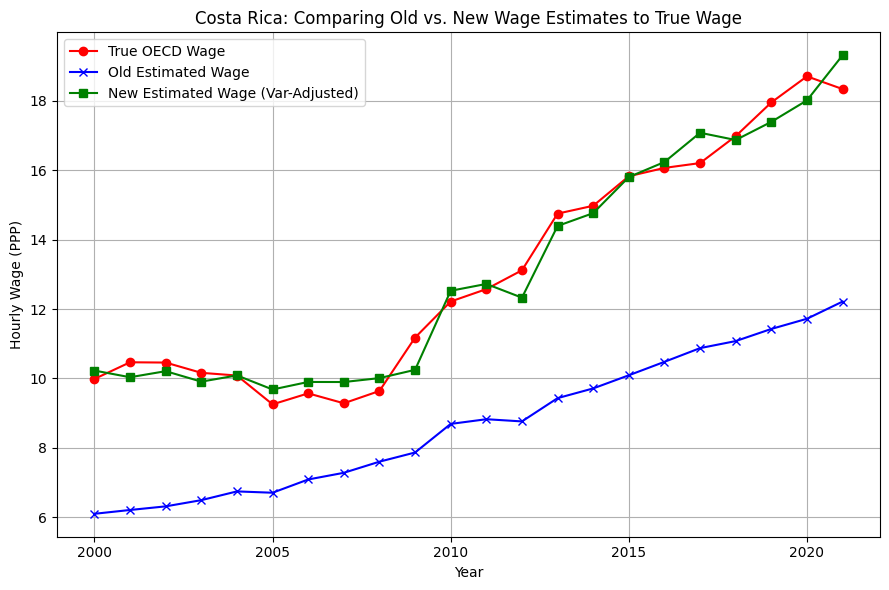

Old Estimate MSE: 21.126
New Var-Adjusted Estimate MSE: 0.250
The new var-adjusted estimate has a lower MSE, indicating a better fit.
                            OLS Regression Results                            
Dep. Variable:       oecd_hourly_wage   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     324.3
Date:                Thu, 15 May 2025   Prob (F-statistic):           1.24e-17
Time:                        22:31:04   Log-Likelihood:                 37.656
No. Observations:                  32   AIC:                            -71.31
Df Residuals:                      30   BIC:                            -68.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.02

In [43]:
# Adjusting Costa Rica wages estimate

# Fixed variables always in the model
fixed_vars = ["year", "log_estimated_hourly_wage"]

# Optional variables to test in combinations
optional_vars = [
    "air_passengers_carried",
    "inbound_outbound_tourism_ratio",
    "agriculture_value_added_per_worker",
]

# Filter data to the years 2000–2020 and drop rows with missing values
df_filtered = df_cr_merged[
    (df_cr_merged["year"] >= 2000) & (df_cr_merged["year"] <= 2020)
].dropna(subset=fixed_vars + optional_vars + ["log_oecd_hourly_wage"])

# Drop any rows that lack data for these key variables
df_cr_model = df_cr_merged.dropna(subset=[
    "year", "log_estimated_hourly_wage",  "air_passengers_carried", "inbound_outbound_tourism_ratio", "agriculture_value_added_per_worker"
]).copy()

# 2. Prepare the regression inputs: predict log_oecd_hourly_wage using year, log_estimated_hourly_wage, and oil_revenue_billion_usd.
X = df_cr_model[["year", "log_estimated_hourly_wage", "air_passengers_carried", "inbound_outbound_tourism_ratio", "agriculture_value_added_per_worker"]]
y = df_cr_model["log_oecd_hourly_wage"]

# Fit the linear regression
model = LinearRegression().fit(X, y)

# Extract coefficients and print them
intercept = model.intercept_
coefs = model.coef_
print(f"Intercept: {intercept:.3f}")
print(f"year coefficient: {coefs[0]:.3f}")
print(f"log_estimated_hourly_wage coefficient: {coefs[1]:.3f}")
print(f"air_passengers_carried coefficient: {coefs[2]:.3f}")
print(f"inbound_outbound_tourism_ratio coefficient: {coefs[3]:.3f}")
print(f"agriculture_value_added_per_worker coefficient: {coefs[4]:.3f}")

# 3. Generate new predictions (on the log scale) and exponentiate to get wage in levels.
df_cr_model["log_estimated_wage_with_cr_var"] = model.predict(X)
df_cr_model["estimated_wage_with_cr_var"] = np.exp(df_cr_model["log_estimated_wage_with_cr_var"])

# 4. Plot the comparison:
plt.figure(figsize=(9,6))

# Plot the true OECD wage (red)
plt.plot(
    df_cr_model["year"],
    df_cr_model["oecd_hourly_wage"],
    marker='o', color='red', label='True OECD Wage'
)

# Plot the old estimated wage (blue)
plt.plot(
    df_cr_model["year"],
    df_cr_model["estimated_hourly_wage"],
    marker='x', color='blue', label='Old Estimated Wage'
)

# Plot the new oil-adjusted wage (green)
plt.plot(
    df_cr_model["year"],
    df_cr_model["estimated_wage_with_cr_var"],
    marker='s', color='green', label='New Estimated Wage (Var-Adjusted)'
)

plt.title("Costa Rica: Comparing Old vs. New Wage Estimates to True Wage")
plt.xlabel("Year")
plt.ylabel("Hourly Wage (PPP)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# 5. Save the plot to a PDF file for LaTeX inclusion
# output_dir = os.path.expanduser('Project_Wage_Convergence')
# os.makedirs(output_dir, exist_ok=True)
# output_file = os.path.join(output_dir, 'Norway_Wage_oil_adjusted_comparison.pdf')
# plt.savefig(output_file)
# print(f"Plot saved to {output_file}")

# 6. Show the plot
plt.show()

# 7. (Optional) Evaluate the fit via MSE
mse_old = np.mean((df_cr_model["estimated_hourly_wage"] - df_cr_model["oecd_hourly_wage"])**2)
mse_new = np.mean((df_cr_model["estimated_wage_with_cr_var"] - df_cr_model["oecd_hourly_wage"])**2)
print(f"Old Estimate MSE: {mse_old:.3f}")
print(f"New Var-Adjusted Estimate MSE: {mse_new:.3f}")

if mse_new < mse_old:
    print("The new var-adjusted estimate has a lower MSE, indicating a better fit.")
else:
    print("The new var-adjusted estimate does not improve MSE compared to the old estimate.")


# make sure df_norway exists and has oecd_hourly_wage & estimated_hourly_wage
log_oecd = np.log(df_cr["oecd_hourly_wage"])
log_est = np.log(df_cr["estimated_hourly_wage"])

# add_constant will now work
X = sm.add_constant(log_est)
model = sm.OLS(log_oecd, X).fit()

print(model.summary())
print("MSE on log-scale:", model.mse_resid)